In [1]:
##Let's see how oxygen concentration looks like on our transict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from pathlib import Path

##Define path name for pre ctd files##
path1 = Path("//Users/mariacristinaalvarez/Documents/PcalO2cal/Southbound")
csv_files1 = path1.glob("*1dbar.cnv")

#import pre ctd files
south_list = [pd.read_csv(file, encoding="ISO-8859-1", delim_whitespace=True, skiprows=311, header=None)
               .assign(filename=file.stem.split("_")[1]) for file in csv_files1]
#concat pre ctd files
south_df = pd.concat(south_list, ignore_index=True)

south_df['CFO2'] = south_df[16]*1.01948

##Importing GEOTRACES files, quality control filtered previosuly
geowest= pd.read_csv('/Users/mariacristinaalvarez/Documents/PcalO2cal/Southbound/WestGeotraces2015_QC.csv')
import gsw
geowest['SA'] =gsw.SA_from_SP(geowest['salinity'], geowest['pressure'], geowest['longitude'], geowest['latitude'])

geowest['CT'] = gsw.conversions.CT_from_t(geowest['SA'],geowest['temperature'], geowest['pressure'])
#Calculate potential density
geowest['potentialDensity'] = gsw.density.sigma0(geowest['SA'], geowest['CT'])

In [2]:
import math 
#constants from Table 1 of Garcia & Gordon for the fit to Benson and Krause (1984)
A0_o2 = 5.80871
A1_o2 = 3.20291
A2_o2 = 4.17887
A3_o2 = 5.10006
A4_o2 = -9.86643e-2
A5_o2 = 3.80369
B0_o2 = -7.01577e-3
B1_o2 = -7.70028e-3
B2_o2 = -1.13864e-2
B3_o2 = -9.51519e-3
C0_o2 = -2.75915e-7
# convert T to scaled temperature
south_df['temp_S'] = np.log((298.15 - south_df[2])/(273.15 + south_df[2]))
south_df['exp_O2umolkg'] = np.exp(A0_o2 + A1_o2*south_df['temp_S'] + A2_o2*(south_df['temp_S']**2) +  A3_o2*(south_df['temp_S']**3 )+ A4_o2*(south_df['temp_S']**4) + A5_o2*(south_df['temp_S']**5) + south_df[24]*(B0_o2 + B1_o2*south_df['temp_S']+ B2_o2*(south_df['temp_S']**2) + B3_o2*(south_df['temp_S']**3))+ C0_o2*(south_df[24]**2) )
south_df['Sat_O2umolkg'] = south_df[15]/south_df['exp_O2umolkg'] 

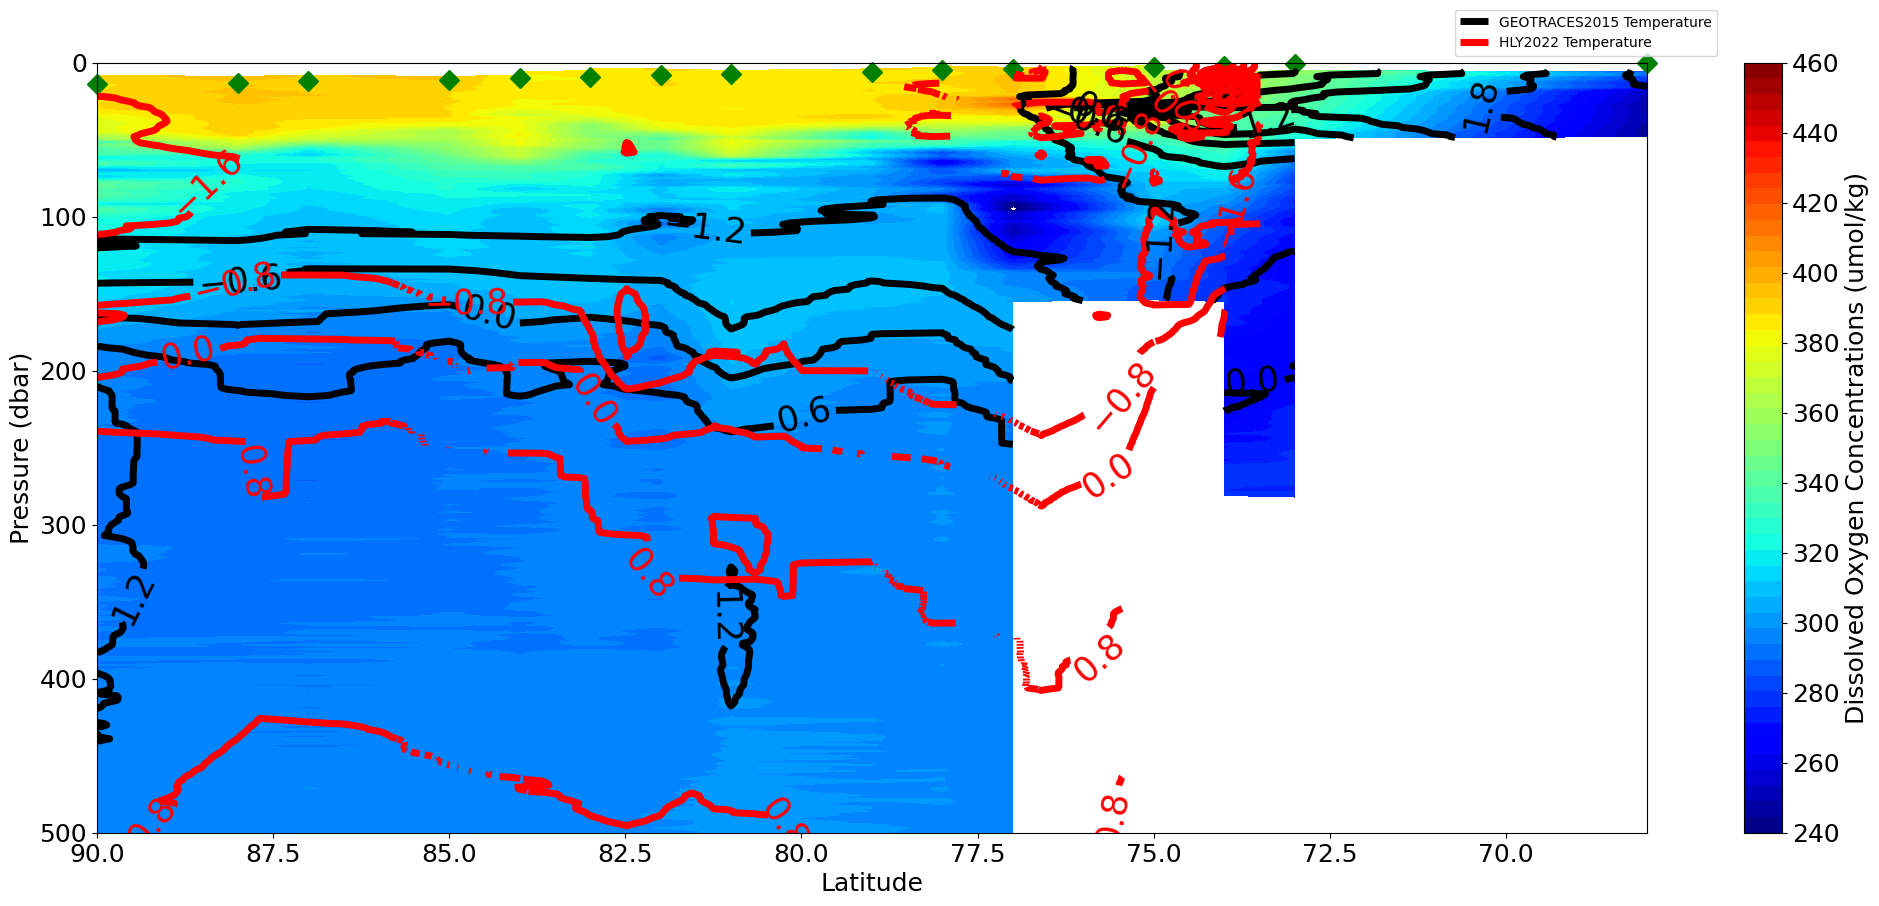

In [4]:

# Creating a pivot table for temperature:
temp_df = south_df.pivot_table(index=0, columns = 19, values=2)
temp_df.interpolate(method='linear')
tempGEO_df = geowest.pivot_table(index='pressure', columns = 'latitude', values='temperature')
tempGEO_df.interpolate(method='linear')
# Creating griddata:
depth = temp_df.index
lati = temp_df.columns
temp = temp_df.values.transpose()
xi, yi = np.meshgrid(lati,depth,indexing='ij')

depthGEO = tempGEO_df.index
latiGEO = tempGEO_df.columns
tempGEO = tempGEO_df.values.transpose()
Xi, Yi = np.meshgrid(latiGEO,depthGEO,indexing='ij')
#Creating contouf for oxygen
south_df[19] = south_df[19].round(decimals=0)
south_df = south_df.sort_index().interpolate(method='linear', limit_area='inside')
pivot_df = south_df.pivot_table(index=0, columns = 19, values='CFO2')
depth2 = pivot_df.index
lati2 = pivot_df.columns
oxygen2 = pivot_df.values.transpose()
zi, wi = np.meshgrid(lati2,depth2,indexing='ij')

#Creating contour plot
plt.figure(figsize=(25,10))
#plt.title(" HLY2202 DISSOLVED OXYGEN CONCENTRATIONS: NORTHERN CANADA BASIN", pad=30, fontsize=18)
plt.xlabel('Latitude',fontsize=18)
plt.ylabel('Pressure (dbar)' ,fontsize=18)
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(top = 0, bottom = 500)
#plt.xlim(left=73, right=90)
levels = np.linspace(240, 460)
plt.contourf(zi,wi,oxygen2, cmap = 'jet', levels=levels,vmin=240, vmax=460)
cbar = plt.colorbar( ticks=(240,260,280,300,320, 340,360,380,400,420,440,460))
plt.plot(lati2,range(len(lati2)), 'gD',clip_on=False, markersize=10, zorder=1)
cbar.set_label('Dissolved Oxygen Concentrations (umol/kg)', fontsize=18)
cbar.ax.tick_params(labelsize=18)
temp = plt.contour(xi, yi, temp , vmin=-1.5, vmax=3.2, linestyles = 'solid', linewidths = 5, colors= 'black')
tempGEO = plt.contour(Xi, Yi, tempGEO , vmin=-1.68, vmax=4.25, linestyles = 'solid', linewidths = 5, colors= 'red')
plt.clabel(temp, inline=1, fontsize=25)
plt.clabel(tempGEO, inline=1, fontsize=25)

h1,_ = temp.legend_elements()
h2,_ = tempGEO.legend_elements()
plt.legend([h1[0],h2[0]], ['GEOTRACES2015 Temperature','HLY2022 Temperature'],bbox_to_anchor=(1.05, 1), loc='lower right' )

In [5]:
geowest['potentialDensity'].min()

18.284670353462957

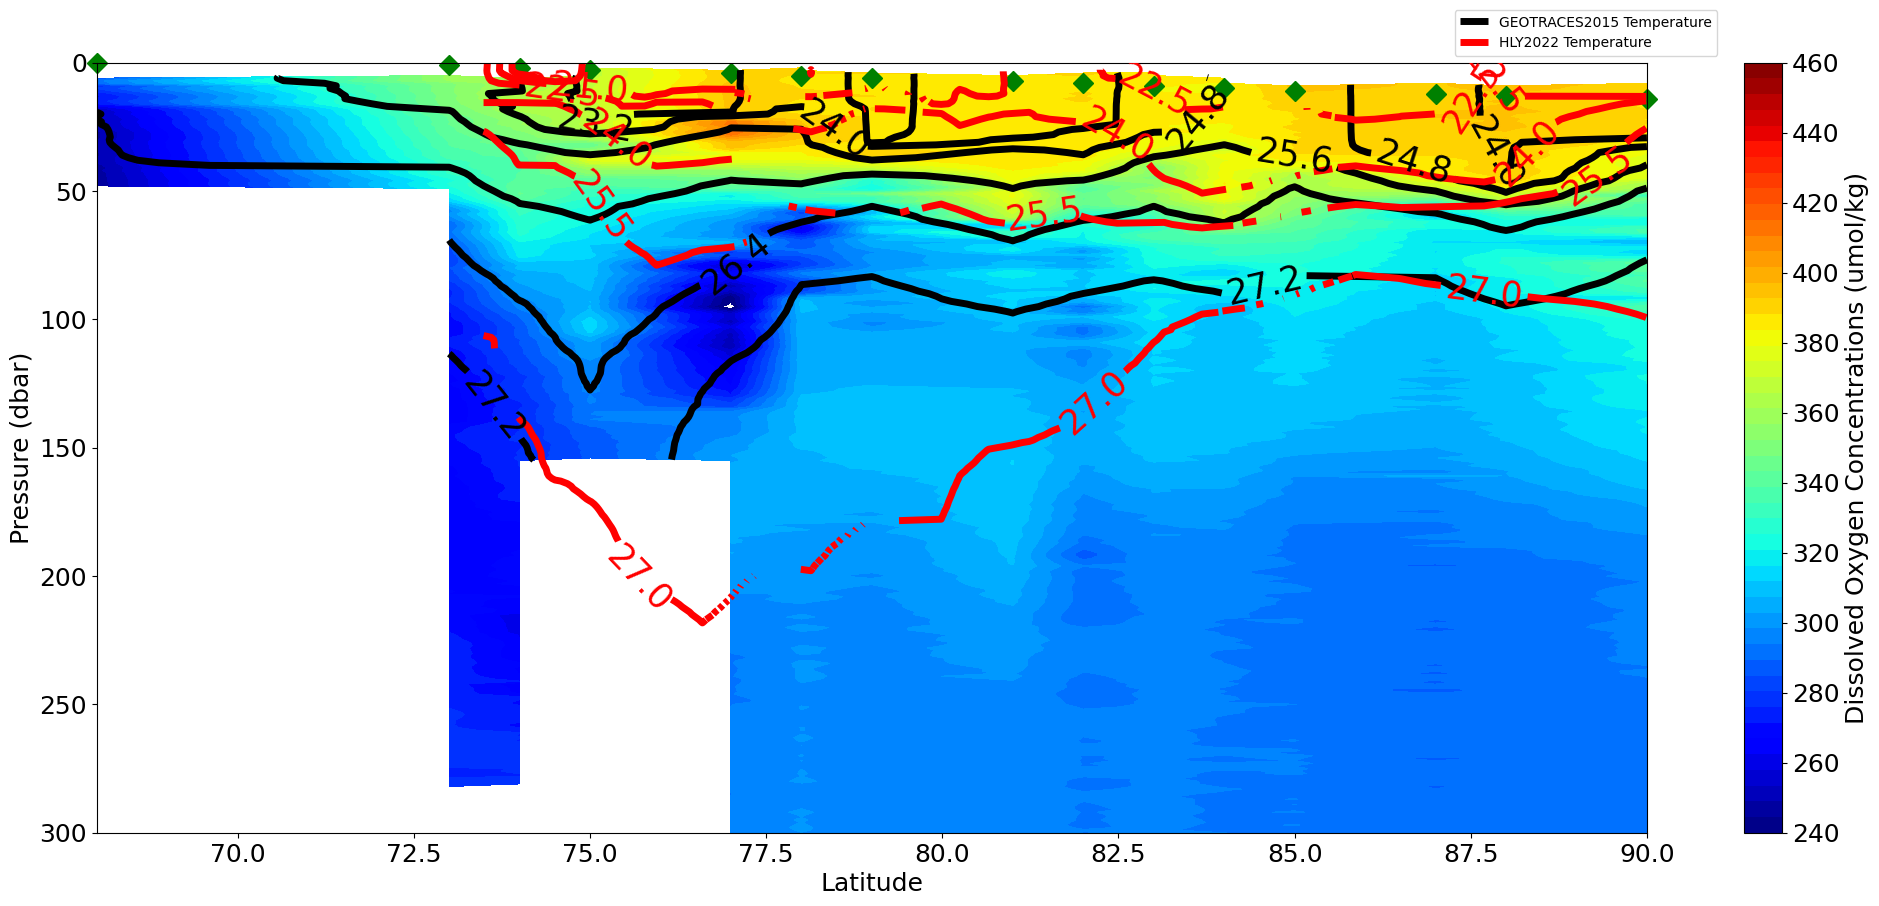

In [9]:
#DENSITY LOTS COMPARISON BOTH DATASETS
# Creating HLY2202 Grid:
density_df = south_df.pivot_table(index=0, columns = 19, values=22)
density_df.dropna()
density_df.drop(index=density_df.index[0], axis=0, inplace=True)
depth3 = density_df.index
lati3 = density_df.columns
density = density_df.values
Xi,Yi = np.meshgrid(lati3,depth3, indexing='ij')


# Creating GEOTRCES DESITY GRID: 
density_GEO = geowest.pivot_table(index='pressure', columns = 'latitude', values='potentialDensity')
#density_df.dropna(
#density_df.drop(index=density_df.index[0], axis=0, inplace=True)
depth_GEO = density_GEO.index
lati_GEO = density_GEO.columns
density_GEO = density_GEO.values
Ai,Bi = np.meshgrid(lati_GEO,depth_GEO, indexing='ij')


#Creating contouf for oxygen
south_df[19] = south_df[19].round(decimals=0)
all_df = south_df.sort_index().interpolate(method='linear', limit_area='inside')
pivot_df = all_df.pivot_table(index=0, columns = 19, values='CFO2')
depth2 = pivot_df.index
lati2 = pivot_df.columns
oxygen2 = pivot_df.values.transpose()
zi, wi = np.meshgrid(lati2,depth2,indexing='ij')

#Creating contour plot
plt.figure(figsize=(25,10))
#plt.title(" HLY2202 DISSOLVED OXYGEN CONCENTRATIONS: NORTHERN CANADA BASIN", pad=30, fontsize=18)
plt.xlabel('Latitude',fontsize=18)
plt.ylabel('Pressure (dbar)' ,fontsize=18)
plt.gca().invert_yaxis()
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(top = 0, bottom = 300)
#plt.xlim(left=73, right=90)
levels = np.linspace(240, 460)
plt.contourf(zi,wi,oxygen2, cmap = 'jet', levels=levels,vmin=240, vmax=460)
cbar = plt.colorbar( ticks=(240,260,280,300,320, 340,360,380,400,420,440,460))
plt.plot(lati2,range(len(lati2)), 'gD',clip_on=False, markersize=10, zorder=1)
cbar.set_label('Dissolved Oxygen Concentrations (umol/kg)', fontsize=18)
cbar.ax.tick_params(labelsize=18)
densi = plt.contour(Xi, Yi, density.T , vmin=20, vmax=29, linestyles = 'solid', linewidths = 5, colors= 'black')
densi_GEO = plt.contour(Ai, Bi, density_GEO.T , vmin=20, vmax=29, linestyles = 'solid', linewidths = 5, colors= 'red')
plt.clabel(densi, inline=1, fontsize=25)
plt.clabel(densi_GEO, inline=1, fontsize=25)

h1,_ = densi.legend_elements()
h2,_ = densi_GEO.legend_elements()
plt.legend([h1[0],h2[0]], ['GEOTRACES2015 Temperature','HLY2022 Temperature'],bbox_to_anchor=(1.05, 1), loc='lower right' )

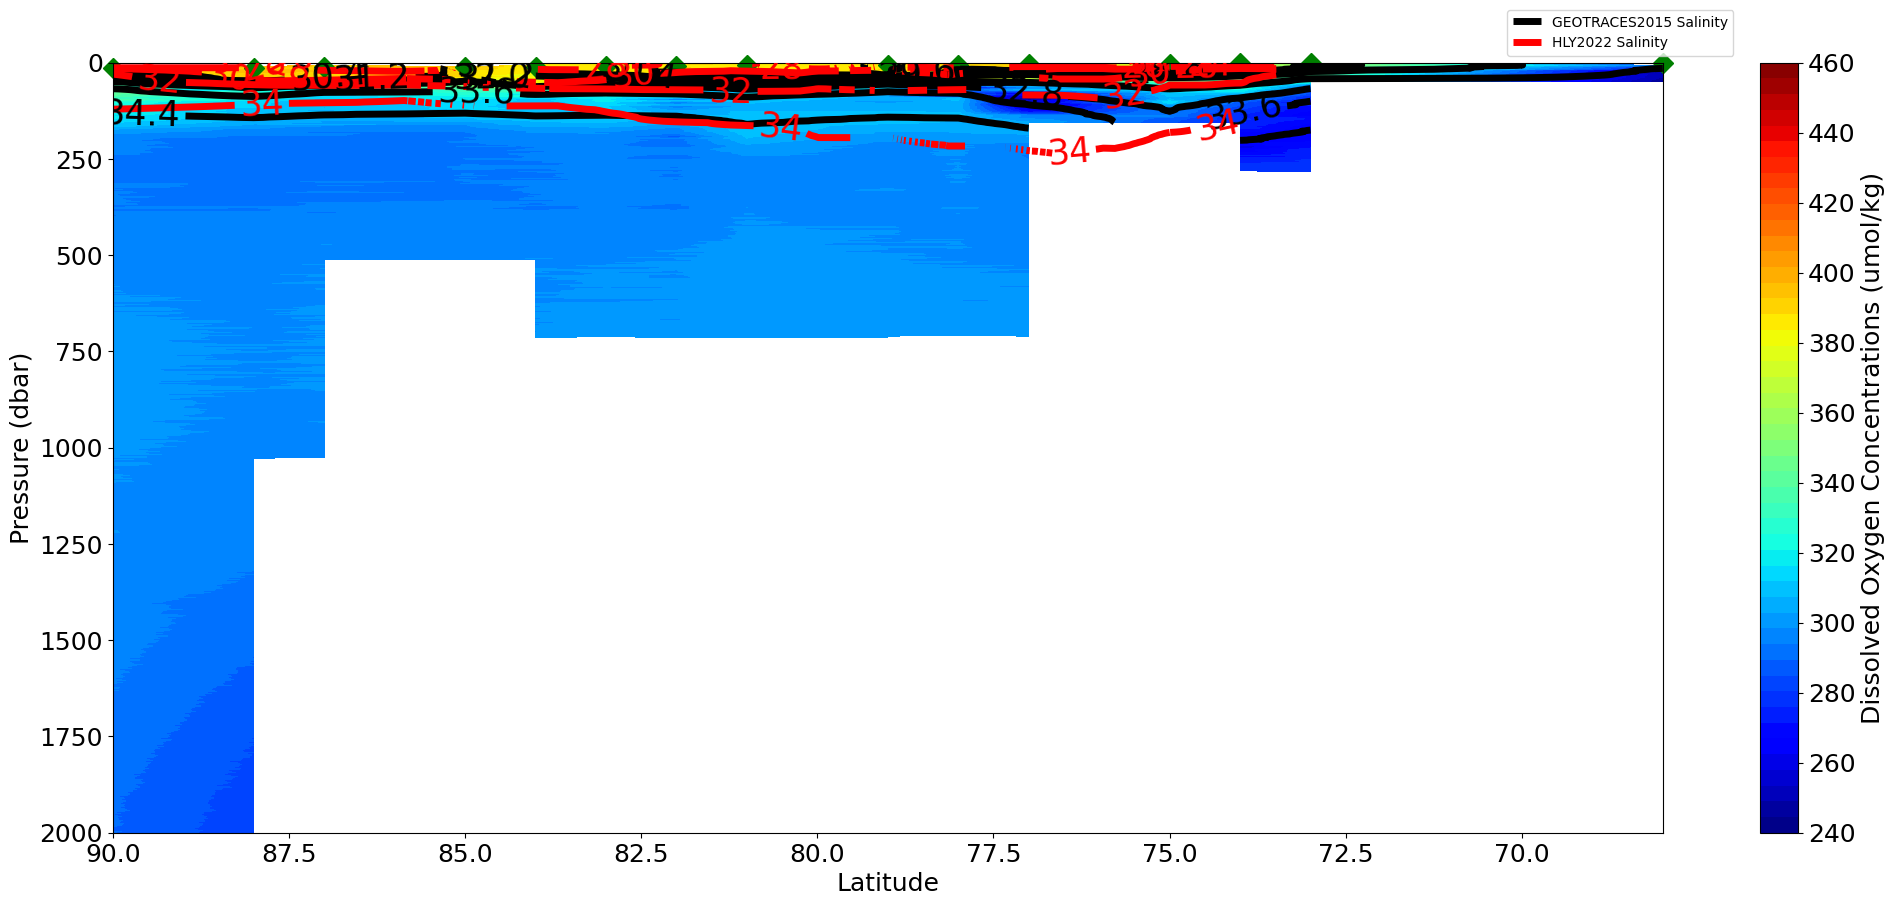

In [7]:
# Creating a pivot table for salinity:
sal_df = south_df.pivot_table(index=0, columns = 19, values=4)
sal_df.interpolate(method='linear')
salGEO_df = geowest.pivot_table(index='pressure', columns = 'latitude', values='salinity')
salGEO_df.interpolate(method='linear')
# Creating griddata:
pressa = sal_df.index
latia = sal_df.columns
sala = sal_df.values.transpose()
ai, bi = np.meshgrid(latia,pressa,indexing='ij')

depthGEO = salGEO_df.index
latiGEO = salGEO_df.columns
salGEO = salGEO_df.values.transpose()
Ai, Bi = np.meshgrid(latiGEO,depthGEO,indexing='ij')


#Creating contouf for oxygen
south_df[19] = south_df[19].round(decimals=0)
south_df = south_df.sort_index().interpolate(method='linear', limit_area='inside')
pivot_df = south_df.pivot_table(index=0, columns = 19, values='CFO2')
depth2 = pivot_df.index
lati2 = pivot_df.columns
oxygen2 = pivot_df.values.transpose()
zi, wi = np.meshgrid(lati2,depth2,indexing='ij')

#Creating contour plot
plt.figure(figsize=(25,10))
#plt.title(" DISSOLVED OXYGEN CONCENTRATIONS: NORTHBOUND CANADA BASIN", pad=30, fontsize=18)
plt.xlabel('Latitude',fontsize=18)
plt.ylabel('Pressure (dbar)' ,fontsize=18)
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(top = 0, bottom = 2000)

levels = np.linspace(240, 460)
plt.contourf(zi,wi,oxygen2, cmap = 'jet', levels=levels,vmin=240, vmax=460)
cbar = plt.colorbar( ticks=(240,260,280,300,320, 340,360,380,400,420,440,460))
plt.plot(lati2,range(len(lati2)), 'gD',clip_on=False, markersize=10, zorder=1)
cbar.set_label('Dissolved Oxygen Concentrations (umol/kg)', fontsize=18)
cbar.ax.tick_params(labelsize=18)
sal = plt.contour(ai, bi, sala , vmin=-1.5, vmax=3.2, linestyles = 'solid', linewidths = 5, colors= 'black')
salGEO = plt.contour(Ai, Bi, salGEO , vmin=-1.68, vmax=4.25, linestyles = 'solid', linewidths = 5, colors= 'red')
plt.clabel(sal, inline=1, fontsize=25)
plt.clabel(salGEO, inline=1, fontsize=25)

h1,_ = sal.legend_elements()
h2,_ = salGEO.legend_elements()
plt.legend([h1[0],h2[0]], ['GEOTRACES2015 Salinity','HLY2022 Salinity'],bbox_to_anchor=(1.05, 1), loc='lower right' )

In [3]:
south_df['AOU'] = south_df['exp_O2umolkg']- south_df['CFO2']

/var/folders/2b/pwxn7kh9125g4k207h_wmc8h0000gn/T/ipykernel_59572/1106861650.py:18: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plot.figure.colorbar(sm, label= 'Dissolved Oxygen Concentrations (umol/kg)', extend='both')


[Text(0.5, 0, 'Salinity [psu]'),
 Text(0, 0.5, 'PotTemperature [degC]'),
 Text(0.5, 1.0, 'HLY2202: Southbound T/S OXYGEN ')]

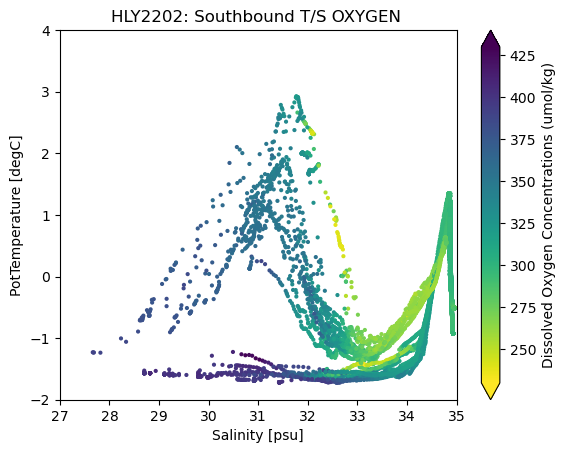

In [4]:
##Plotting all stations colored by latitude and longitude

import seaborn as sns
import colorcet as cc

#custom_palette = sns.color_palette("viridis", 29)
#palette = sns.color_palette("magma", n_colors=31)

plot = sns.scatterplot(x=24,
            y=23,
            data=south_df,
            hue='CFO2',palette= "viridis_r",marker='.',linewidth=0, legend= False)
plot.set(ylim = (-2.0,4.0))
plot.set(xlim = (27,35))
norm = plt.Normalize(230,430)
sm = plt.cm.ScalarMappable(cmap="viridis_r", norm=norm)
sm.set_array([])
plot.figure.colorbar(sm, label= 'Dissolved Oxygen Concentrations (umol/kg)', extend='both')

plot.set(xlabel ="Salinity [psu]", ylabel = "PotTemperature [degC]", title= 'HLY2202: Southbound T/S OXYGEN ')
#plt.show()

/var/folders/2b/pwxn7kh9125g4k207h_wmc8h0000gn/T/ipykernel_59572/1574203098.py:18: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plot.figure.colorbar(sm, label= 'Dissolved Oxygen Concentrations (umol/kg)', extend='both')


[Text(0.5, 0, 'Salinity [psu]'),
 Text(0, 0.5, 'PotTemperature [degC]'),
 Text(0.5, 1.0, 'HLY2202: Southbound T/S AOU')]

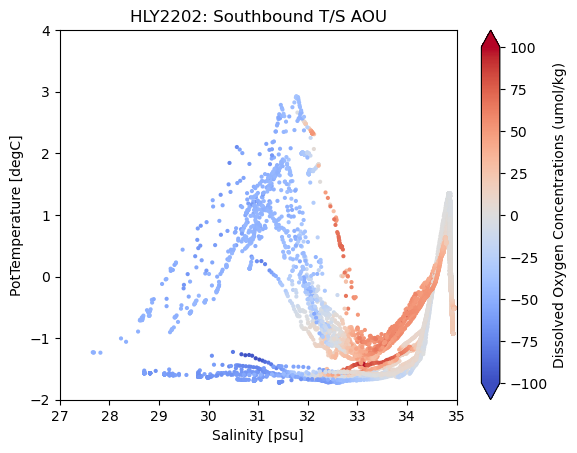

In [5]:
##Plotting all stations colored by latitude and longitude

import seaborn as sns
import colorcet as cc

#custom_palette = sns.color_palette("viridis", 29)
#palette = sns.color_palette("magma", n_colors=31)

plot = sns.scatterplot(x=24,
            y=23,
            data=south_df,
            hue='AOU',palette= "coolwarm",marker='.',linewidth=0, legend= False)
plot.set(ylim = (-2.0,4.0))
plot.set(xlim = (27,35))
norm = plt.Normalize(-100.0, 100)
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
sm.set_array([])
plot.figure.colorbar(sm, label= 'Dissolved Oxygen Concentrations (umol/kg)', extend='both')
plot.set(xlabel ="Salinity [psu]", ylabel = "PotTemperature [degC]", title= 'HLY2202: Southbound T/S AOU')
#plt.show()

In [5]:
south_df[18] = south_df[18].round(decimals=0)
south_df = south_df.sort_index().interpolate(method='nearest')
aou_df = south_df.pivot_table(index=0, columns = 18, values='AOU')

In [11]:
south_df['AOU'].min(),south_df['AOU'].max()

(-36.14409215149834, 134.16283483619384)

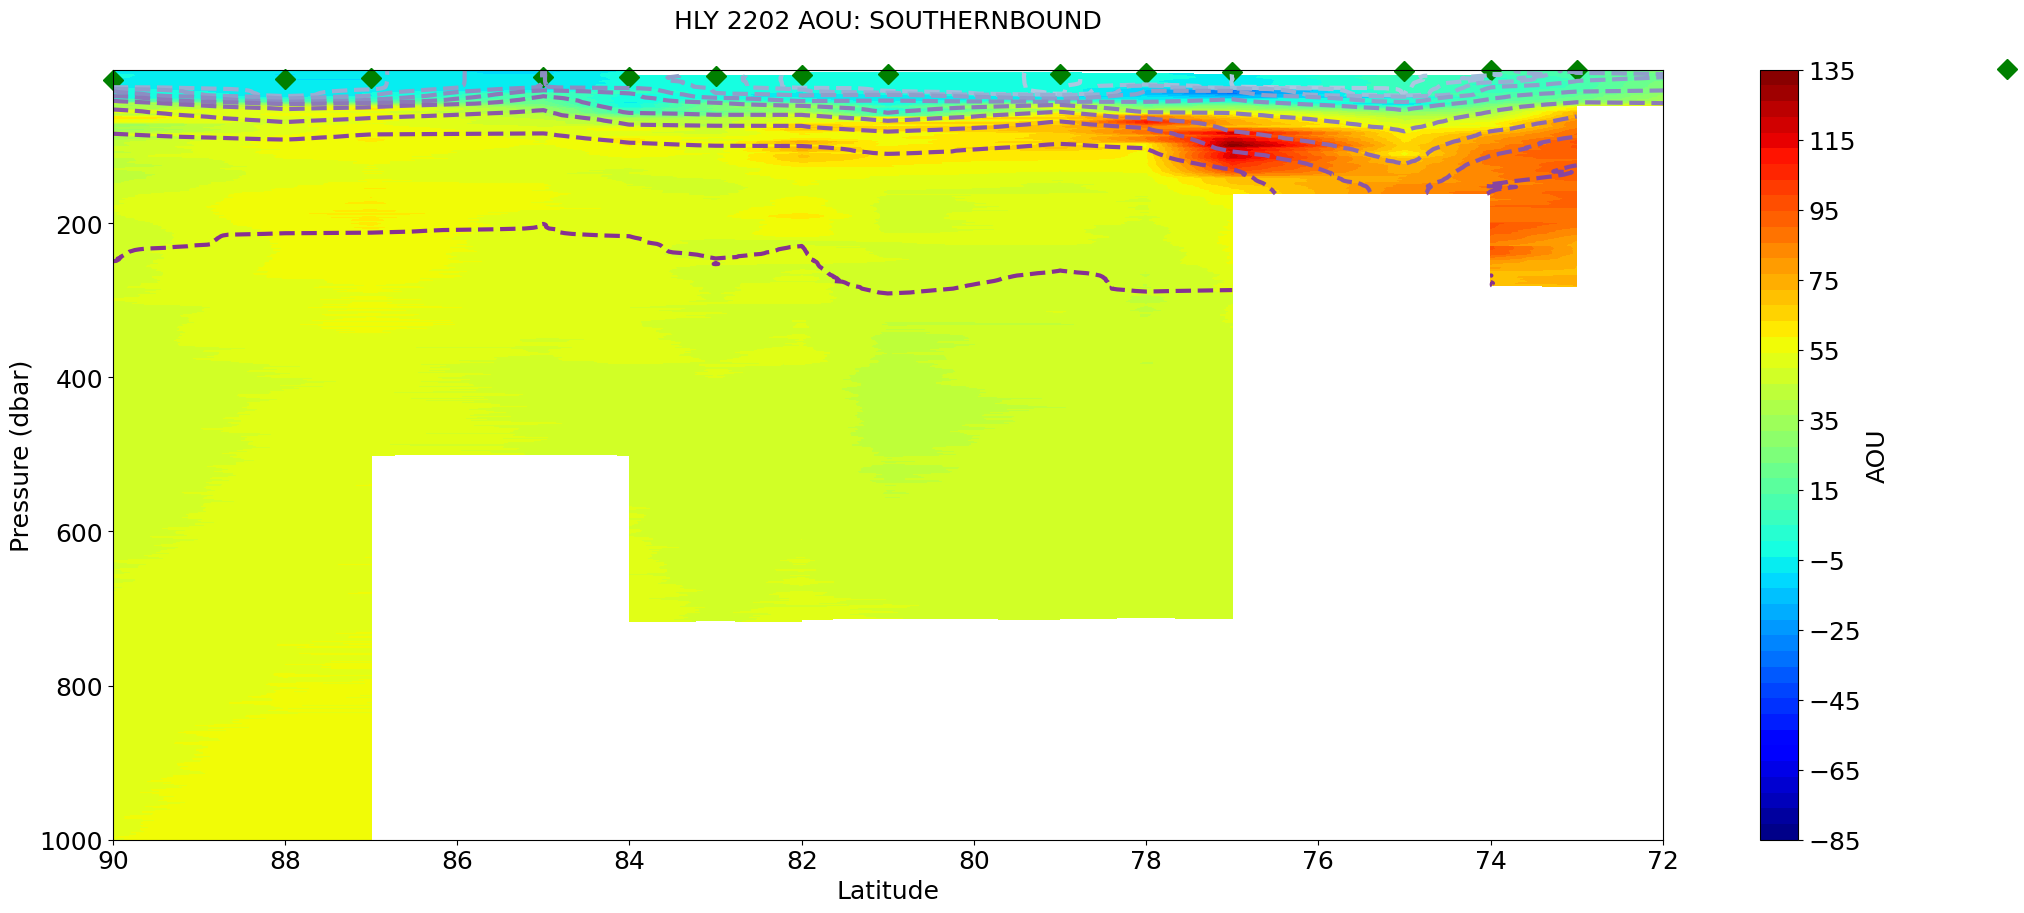

In [36]:
south_df[18] = south_df[18].round(decimals=0)
south_df = south_df.sort_index().interpolate(method='linear', limit_area='inside')
aou_df = south_df.pivot_table(index=0, columns = 18, values='AOU')
depth2 = aou_df.index
lati2 = aou_df.columns
oxygen2 = aou_df.values.transpose()
xi, yi = np.meshgrid(lati2,depth2,indexing='ij')
#from matplotlib.colors import LogNorm
plt.figure(figsize=(25,10))
levels = np.linspace(-85, 135)
plt.contourf(xi,yi,oxygen2, cmap = 'jet', levels=levels,vmin=-85, vmax=135)
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
cbar = plt.colorbar(ticks=(-85,-65,-45,-25,-5,15,35,55,75,95, 115,135))
cbar.set_label('AOU', fontsize=18)
cbar.ax.tick_params(labelsize=18)
plt.xlabel('Latitude',fontsize=18)
plt.ylabel('Pressure (dbar)' ,fontsize=18)
plt.ylim(bottom = 1000)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.plot(lati2,range(len(lati2)),'gD', clip_on=False, markersize=10)
plt.xlim(right = 72)
plt.title("HLY 2202 AOU: SOUTHERNBOUND", pad=30, fontsize=18)

##Creating matrix for density tables
density_df = south_df.pivot_table(index=0, columns = 18, values=22)
density_df.dropna()
density_df.drop(index=density_df.index[0], axis=0, inplace=True)
depth3 = density_df.index
lati3 = density_df.columns
density = density_df.values.transpose()
Xi,Yi = np.meshgrid(lati3,depth3, indexing='ij')
levels2 = np.linspace(20,30,num= 20)
density = plt.contour(Xi, Yi, density , levels = levels2, linestyles = 'dashed', linewidths = 3, cmap = 'BuPu' )
#plt.savefig("HLY2202_O2_SouthernBound(1000m).png",facecolor='white',transparent = False)

(array([1000., 1500., 2000., 2500., 3000., 3500., 4000., 4500.]),
 [Text(0, 1000.0, '1000'),
  Text(0, 1500.0, '1500'),
  Text(0, 2000.0, '2000'),
  Text(0, 2500.0, '2500'),
  Text(0, 3000.0, '3000'),
  Text(0, 3500.0, '3500'),
  Text(0, 4000.0, '4000'),
  Text(0, 4500.0, '4500')])

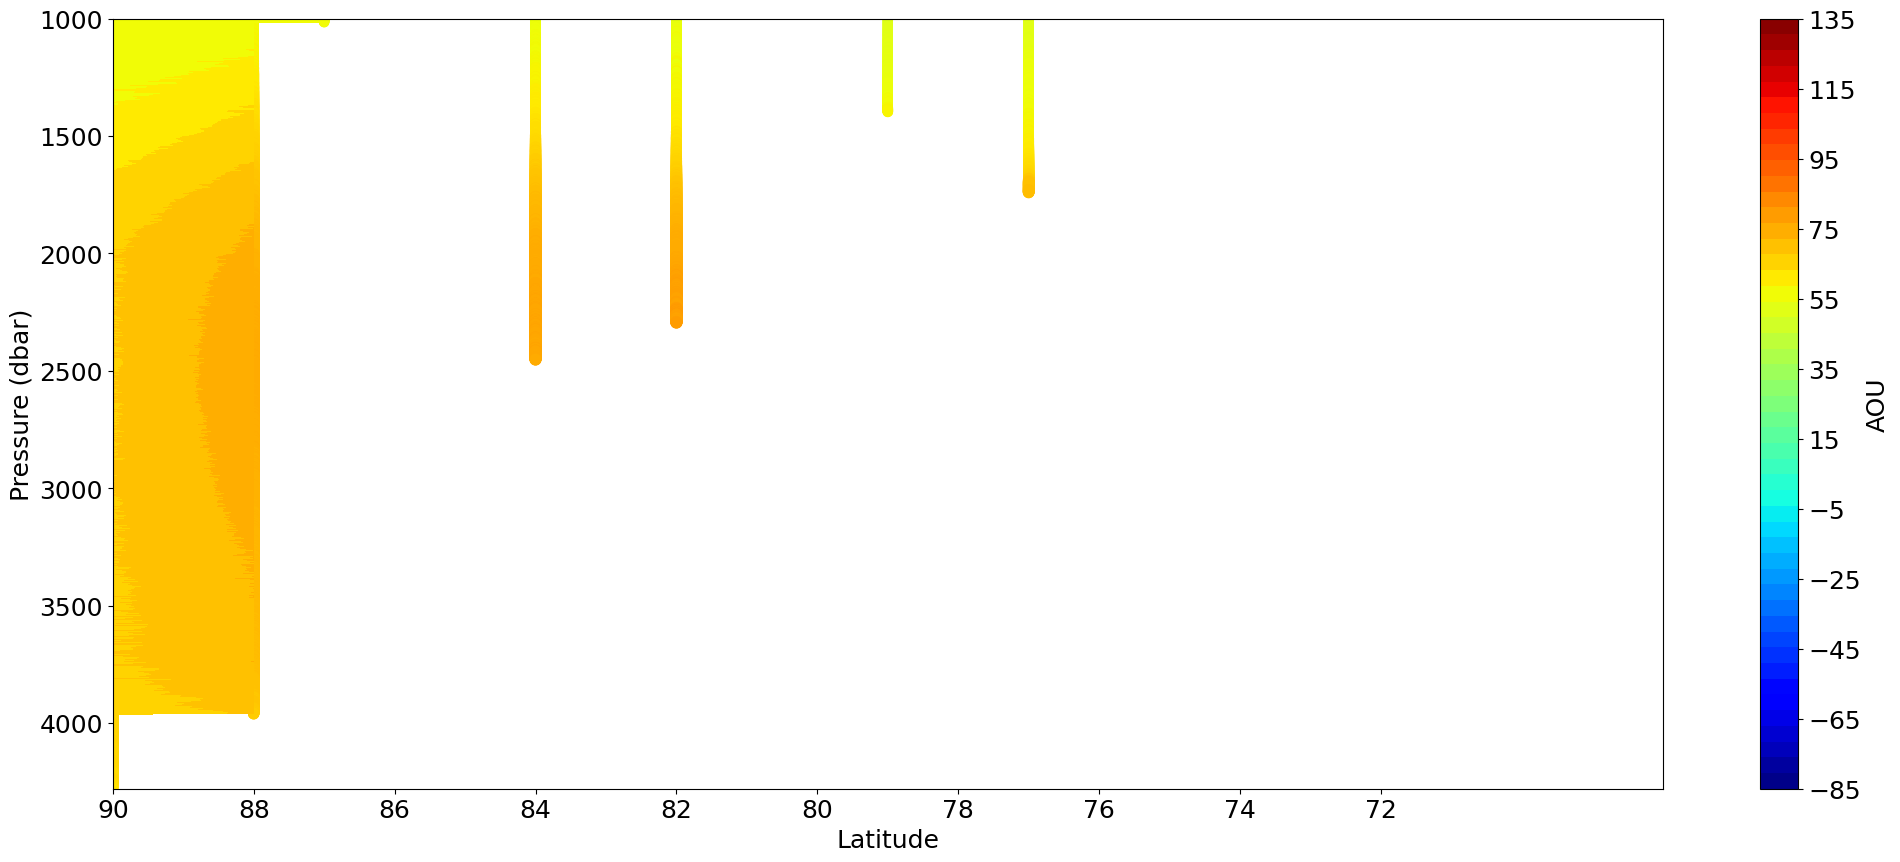

In [37]:
###AOU plots using exp. 
lower_1000 = south_df.loc[south_df[0] >= 1000]
lower1000df = lower_1000.pivot_table(index=0, columns = 18, values='AOU')

y2 = lower_1000[0]
x2 = lower_1000[18]
z2 = lower_1000['AOU']
#xi, yi = np.meshgrid(lati2,depth2,indexing='ij')
#from matplotlib.colors import LogNorm
plt.figure(figsize=(25,10))

plt.scatter(x2,y2,z2, cmap = 'jet',c=z2 , linewidths=50,vmin=-85,vmax=135 , edgecolors='none')
levels = np.linspace(-85,135)
plt.contourf(xi,yi,oxygen2, cmap = 'jet',levels = levels, vmin=-85, vmax=135)
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.xticks([72,74,76,78,80,82,84,86,88,90])
cbar = plt.colorbar(ticks=(-85,-65,-45,-25,-5,15,35,55,75,95, 115,135))
cbar.set_label('AOU', fontsize=18)
cbar.ax.tick_params(labelsize=18)
plt.xlabel('Latitude',fontsize=18)
plt.ylabel('Pressure (dbar)' ,fontsize=18)
plt.ylim(top = 1000)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
#density = plt.contour(Xi, Yi, density , linestyles = 'dashed', linewidths = 3, cmap = 'Accent' )
#plt.clabel(density, inline=1, fontsize=10)

(90.0, 72.0)

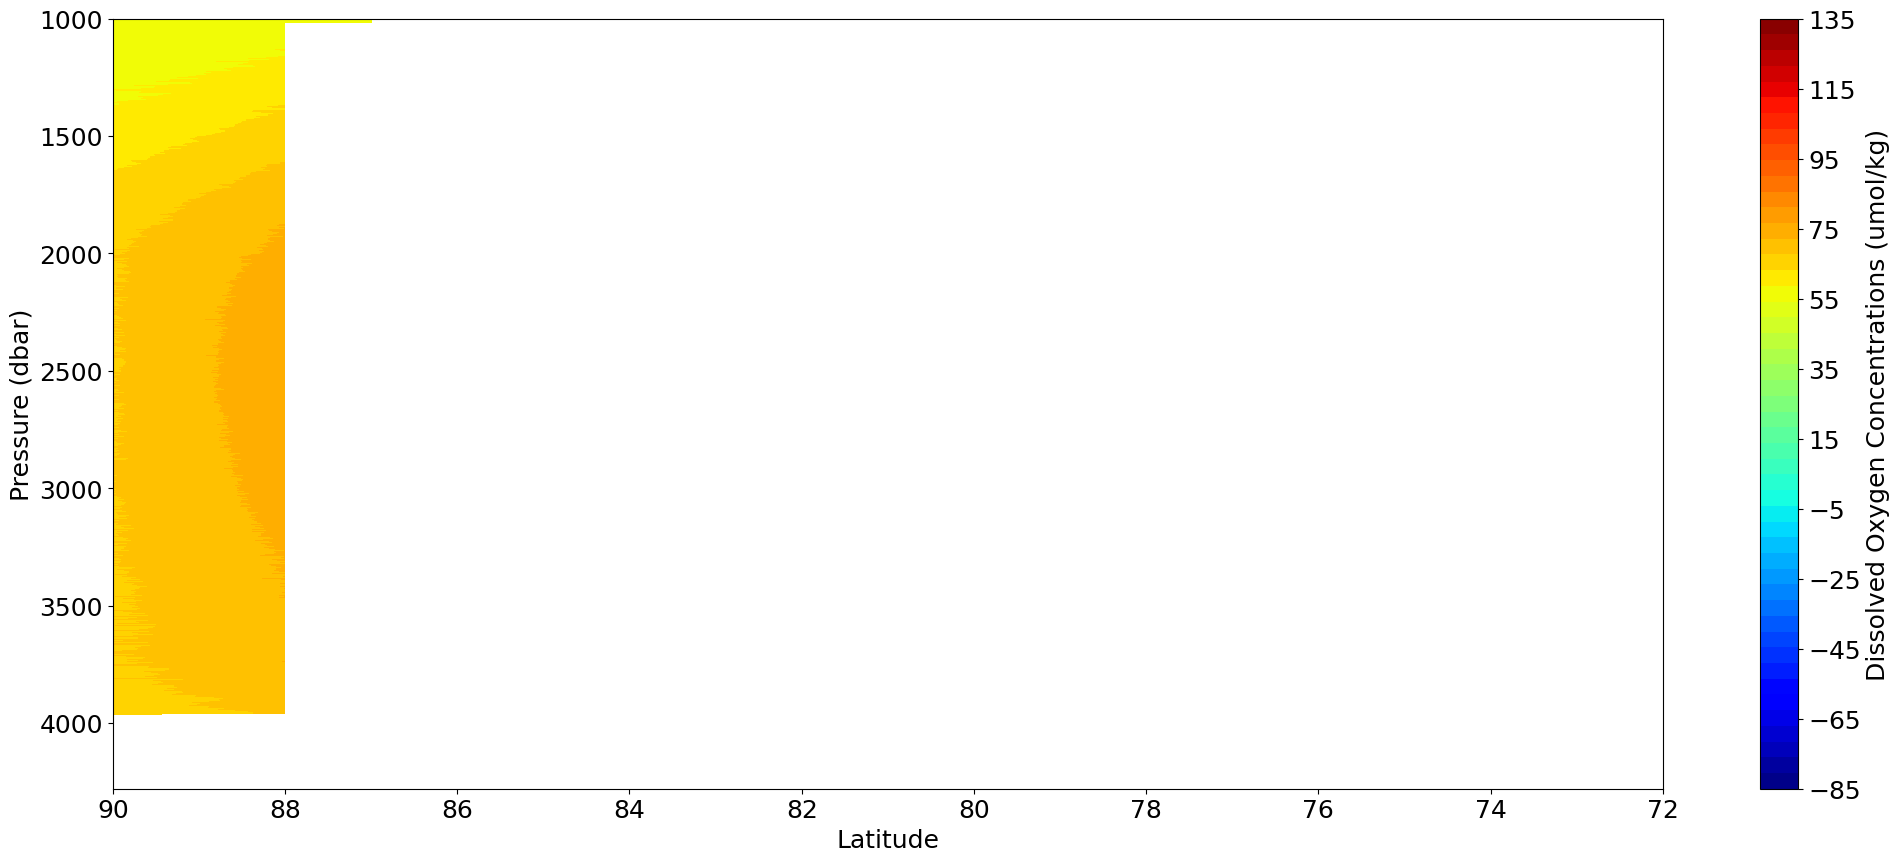

In [8]:

depth2 = aou_df.index
lati2 = aou_df.columns
oxygen2 = aou_df.values.transpose()
xi, yi = np.meshgrid(lati2,depth2,indexing='ij')
#from matplotlib.colors import LogNorm
plt.figure(figsize=(25,10))
levels = np.linspace(-85, 135)
plt.contourf(xi,yi,oxygen2, cmap = 'jet', levels=levels,vmin=-85, vmax=135)
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
cbar = plt.colorbar(ticks=(-85,-65,-45,-25,-5,15,35,55,75,95, 115,135))
cbar.set_label('Dissolved Oxygen Concentrations (umol/kg)', fontsize=18)
cbar.ax.tick_params(labelsize=18)
plt.xlabel('Latitude',fontsize=18)
plt.ylabel('Pressure (dbar)' ,fontsize=18)
plt.ylim(top = 1000)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlim(right = 72)

#plt.savefig("HLY2202_O2_SouthernBound(1000m).png",facecolor='white',transparent = False)

In [10]:
south_df[18] = south_df[18].round(decimals=0)
south_df = south_df.sort_index().interpolate(method='nearest')
pivot_df = south_df.pivot_table(index=0, columns = 18, values='CFO2')

In [33]:
##Creating matrix for density tables
density_df = big_df.pivot_table(index=0, columns = 15, values=20)
density_df.dropna()
density_df.drop(index=density_df.index[0], axis=0, inplace=True)
depth3 = density_df.index
lati3 = density_df.columns
density = density_df.values.transpose()
Xi,Yi = np.meshgrid(lati3,depth3, indexing='ij')

<a list of 6 text.Text objects>

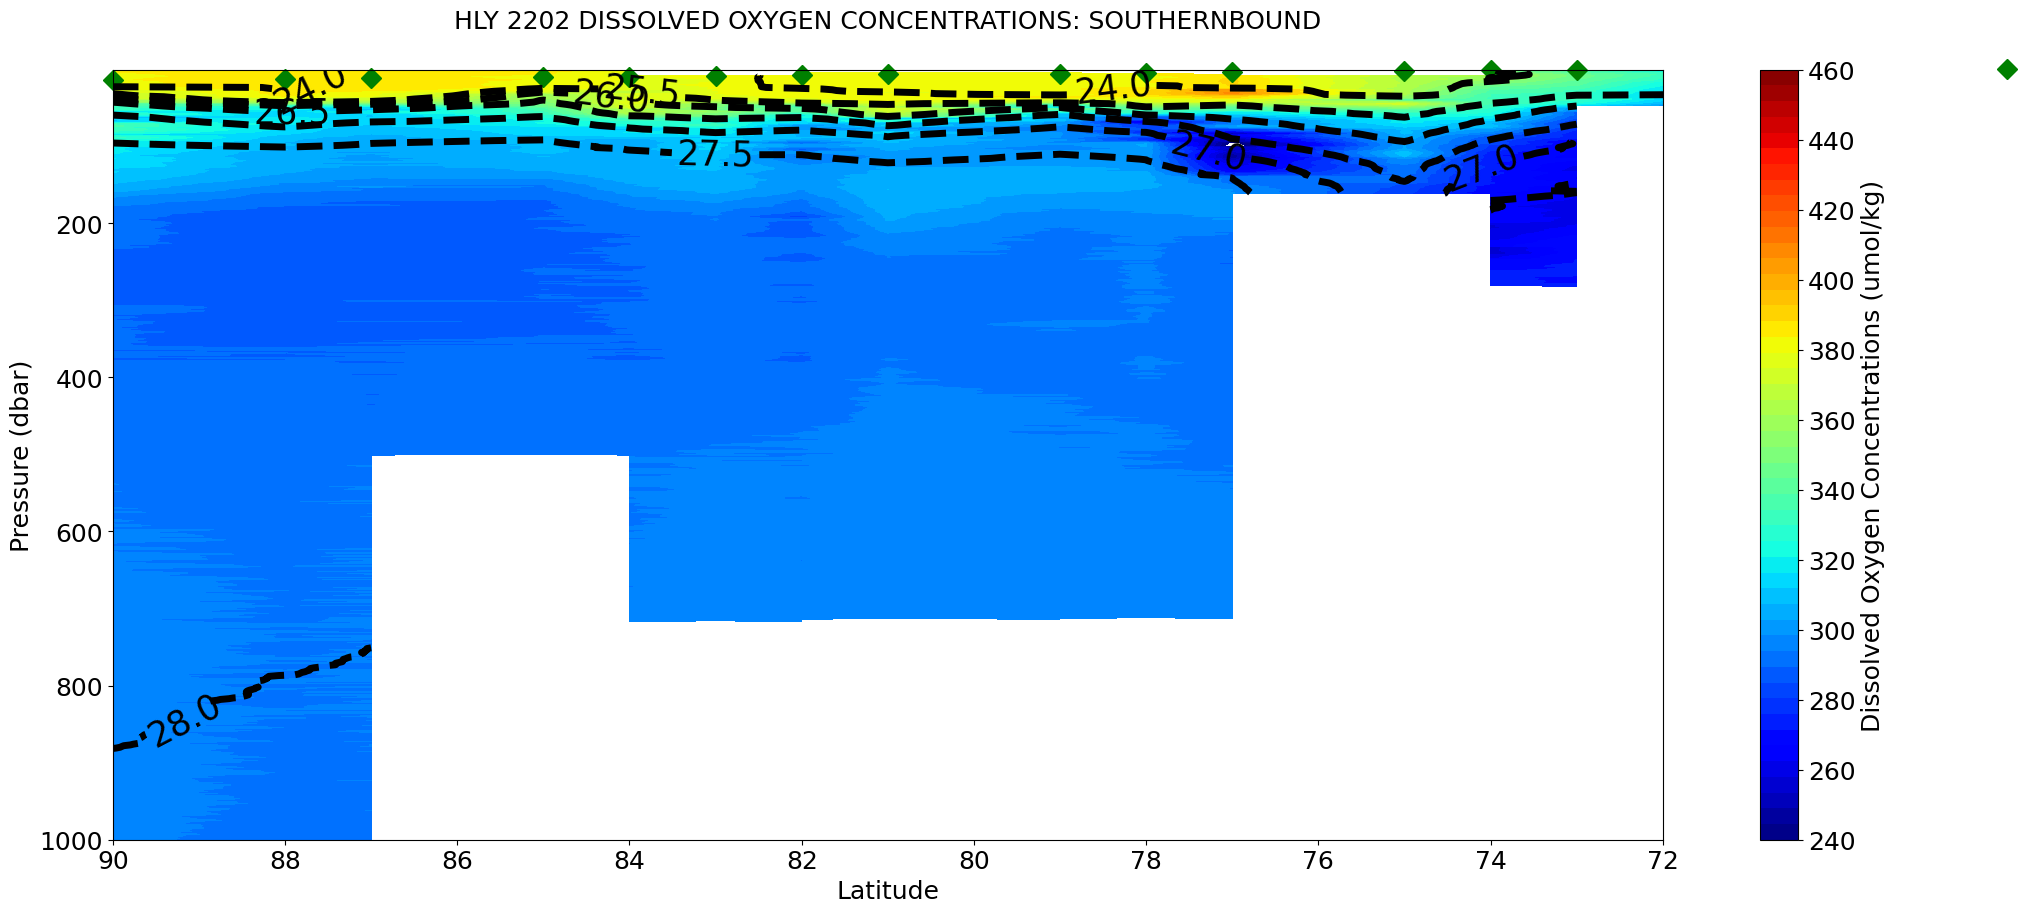

In [7]:
south_df[18] = south_df[18].round(decimals=0)
south_df = south_df.sort_index().interpolate(method='nearest')
pivot_df = south_df.pivot_table(index=0, columns = 18, values='CFO2')

##Creating matrix for density tables
density_df = south_df.pivot_table(index=0, columns = 18, values=22)
density_df.dropna()
density_df.drop(index=density_df.index[0], axis=0, inplace=True)
depth3 = density_df.index
lati3 = density_df.columns
density = density_df.values
Xi,Yi = np.meshgrid(lati3,depth3, indexing='ij')

depth2 = pivot_df.index
lati2 = pivot_df.columns
oxygen2 = pivot_df.values.transpose()
xi, yi = np.meshgrid(lati2,depth2,indexing='ij')
#from matplotlib.colors import LogNorm
plt.figure(figsize=(25,10))
levels = np.linspace(240, 460)
plt.contourf(xi,yi,oxygen2, cmap = 'jet', levels=levels,vmin=240, vmax=460)
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
cbar = plt.colorbar( ticks=(240,260,280,300,320, 340,360,380,400,420,440,460))

cbar.set_label('Dissolved Oxygen Concentrations (umol/kg)', fontsize=18)
cbar.ax.tick_params(labelsize=18)
plt.xlabel('Latitude',fontsize=18)
plt.ylabel('Pressure (dbar)' ,fontsize=18)
plt.ylim(bottom = 1000)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.plot(lati2,range(len(lati2)),'gD', clip_on=False, markersize=10)
plt.xlim(right = 72)
plt.title("HLY 2202 DISSOLVED OXYGEN CONCENTRATIONS: SOUTHERNBOUND", pad=30, fontsize=18)
levels2 = np.linspace(24,25.5, 2)
levels3 = (26,26.5,27.0, 27.5, 28.0) 
density1 = plt.contour(Xi, Yi, density.T , levels = levels2,vmin=24,vmax=26, linestyles = 'dashed', linewidths = 5, colors= 'black')
density2 = plt.contour(Xi, Yi, density.T ,levels=levels3, vmin=26, vmax=28, linestyles = 'dashed', linewidths = 5, colors= 'black')
plt.clabel(density1, inline=1, fontsize=25)
plt.clabel(density2, inline=1, fontsize=25)


(array([1000., 1500., 2000., 2500., 3000., 3500., 4000., 4500.]),
 [Text(0, 1000.0, '1000'),
  Text(0, 1500.0, '1500'),
  Text(0, 2000.0, '2000'),
  Text(0, 2500.0, '2500'),
  Text(0, 3000.0, '3000'),
  Text(0, 3500.0, '3500'),
  Text(0, 4000.0, '4000'),
  Text(0, 4500.0, '4500')])

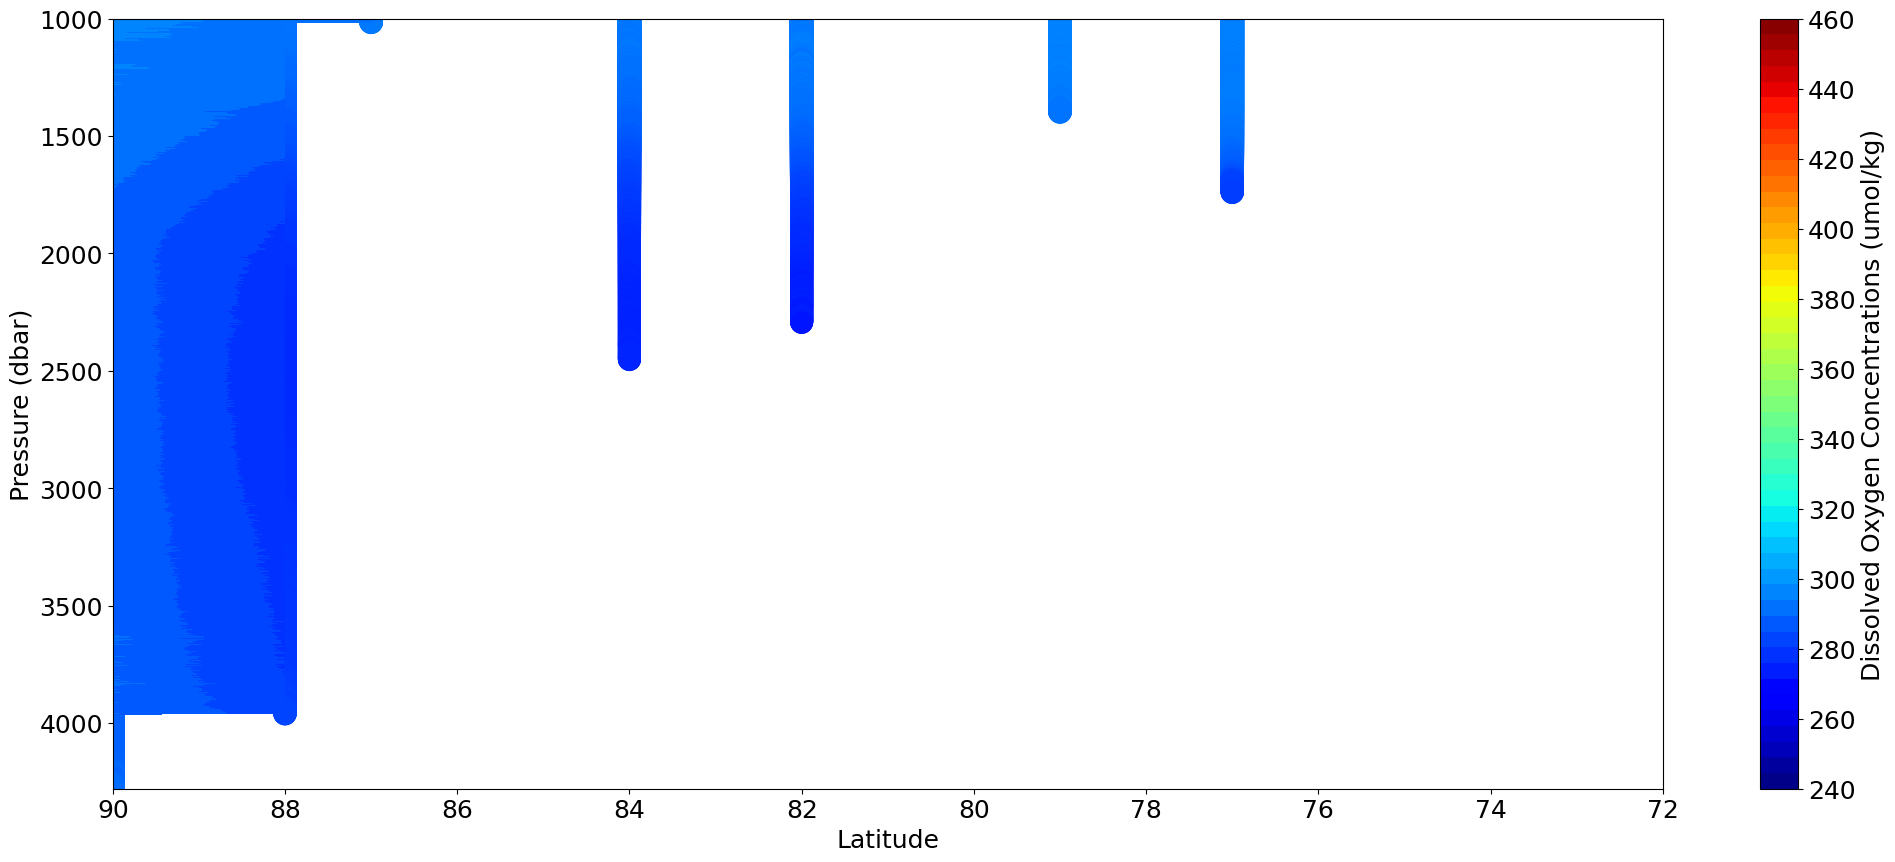

In [33]:
lower_1000 = south_df.loc[south_df[0] >= 1000]
lower1000df = lower_1000.pivot_table(index=0, columns = 18, values='CFO2')

#y = lower1000df.index
#x = lower1000df.columns
#color = lower1000df.values.transpose()
y = lower_1000[0]
x = lower_1000[18]
z = lower_1000['CFO2']
#from matplotlib.colors import LogNorm
plt.figure(figsize=(25,10))

plt.scatter(x,y,z, cmap = 'jet', c=z, linewidths=50, vmin=240,vmax=460, edgecolors='none')
levels = np.linspace(240, 460)
plt.contourf(xi,yi,oxygen2, cmap = 'jet', levels=levels,vmin=240, vmax=460)
plt.gca().invert_yaxis()
plt.xticks([72,74,76,78,80,82,84,86,88,90])
plt.gca().invert_xaxis()
cbar = plt.colorbar( ticks=(240,260,280,300,320, 340,360,380,400,420,440,460))
cbar.set_label('Dissolved Oxygen Concentrations (umol/kg)', fontsize=18)
cbar.ax.tick_params(labelsize=18)
plt.xlabel('Latitude',fontsize=18)
plt.ylabel('Pressure (dbar)' ,fontsize=18)
plt.ylim(top= 1000)
plt.xlim(right= 72)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)


<a list of 16 text.Text objects>

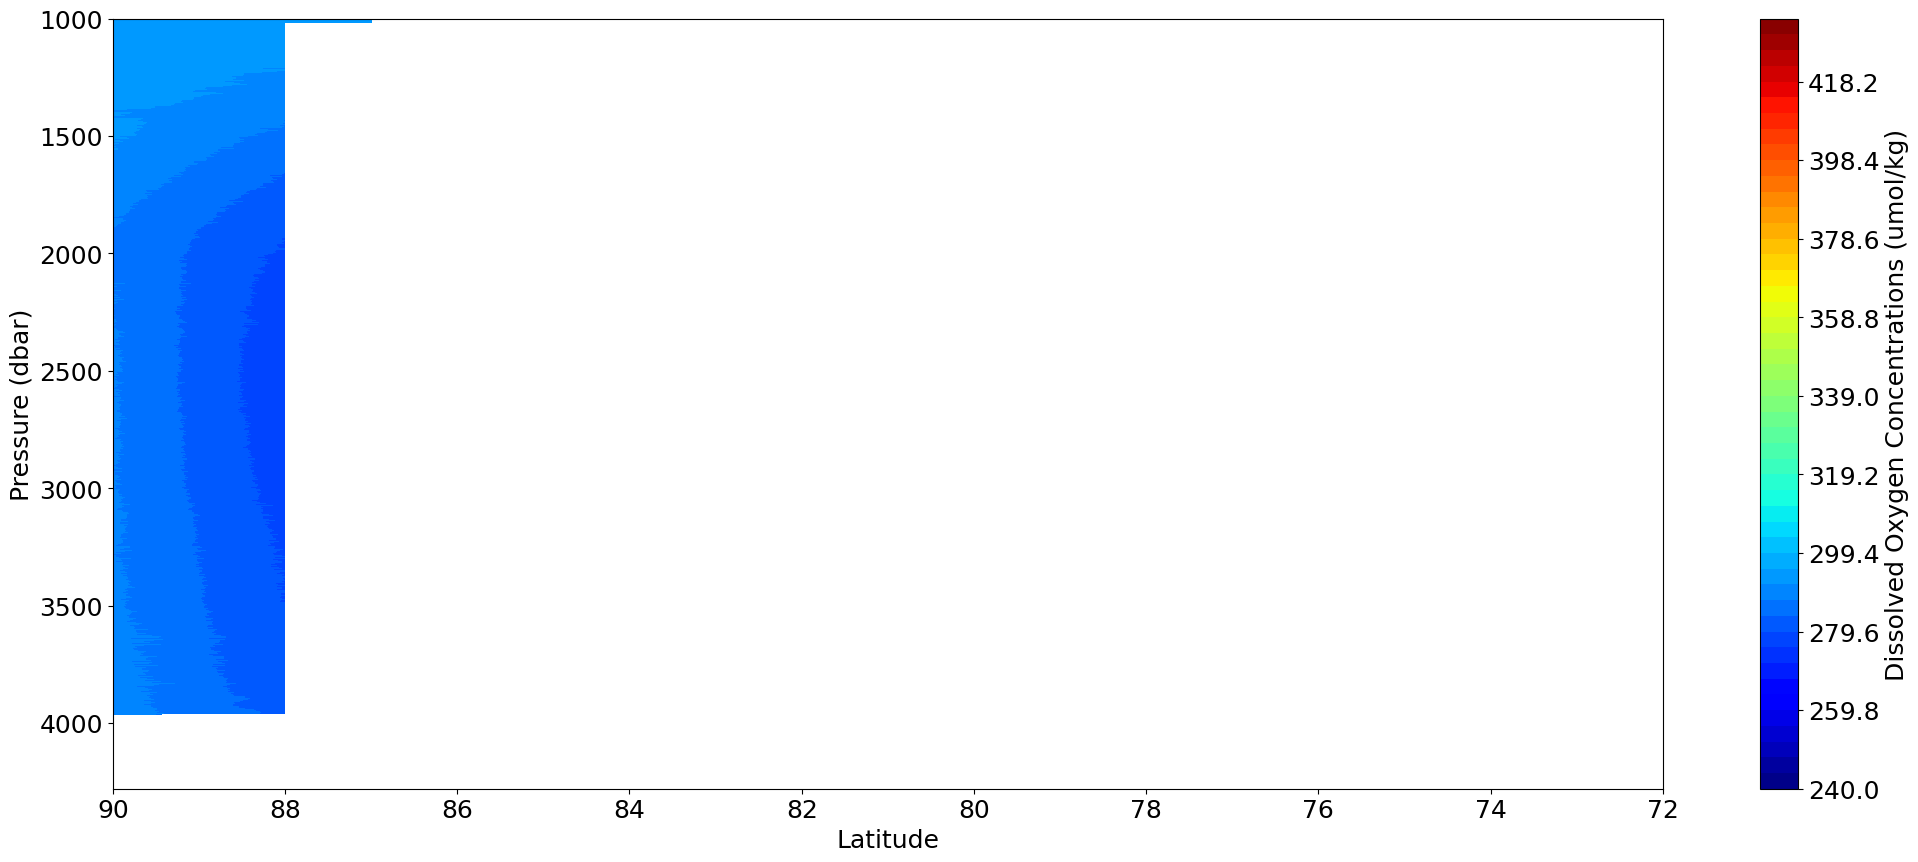

In [15]:
##Creating matrix for density tables
density_df = south_df.pivot_table(index=0, columns = 18, values=22)
density_df.dropna()
density_df.drop(index=density_df.index[0], axis=0, inplace=True)
depth3 = density_df.index
lati3 = density_df.columns
density = density_df.values.transpose()
Xi,Yi = np.meshgrid(lati3,depth3, indexing='ij')
y = lower_1000[0]
x = lower_1000[18]
z = lower_1000['CFO2']
depth2 = pivot_df.index
lati2 = pivot_df.columns
oxygen2 = pivot_df.values.transpose()
xi, yi = np.meshgrid(lati2,depth2,indexing='ij')
#from matplotlib.colors import LogNorm
plt.figure(figsize=(25,10))
levels = np.linspace(240, 460)
plt.scatter(x,y,z, cmap = 'jet', c=z, linewidths=50, vmin=240,vmax=460, edgecolors='none')
plt.contourf(xi,yi,oxygen2, cmap = 'jet', levels=levels,vmin=240, vmax=434)
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
cbar = plt.colorbar(extend ='both')
cbar.set_label('Dissolved Oxygen Concentrations (umol/kg)', fontsize=18)
cbar.ax.tick_params(labelsize=18)
plt.xlabel('Latitude',fontsize=18)
plt.ylabel('Pressure (dbar)' ,fontsize=18)
plt.ylim(top = 1000)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.xlim(right = 72)

levels2 = np.linspace(20,30,num= 20)
density = plt.contour(Xi, Yi, density , levels = levels2, linestyles = 'dashed', linewidths = 3, cmap = 'spring' )
plt.clabel(density, inline=1, fontsize=10)


In [10]:
##Plotting for Temperature
pivot_T = south_df.pivot_table(index=0, columns = 18, values=2)

In [20]:
##Creating matrix for density tables
density_df = big_df.pivot_table(index=1, columns = 15, values=20)
density_df.dropna()
density_df.drop(index=density_df.index[0], axis=0, inplace=True)
depth3 = density_df.index
lati3 = density_df.columns
density = density_df.values.transpose()
Xi,Yi = np.meshgrid(lati3,depth3, indexing='ij')

In [12]:
south_df[2].max()

2.9284

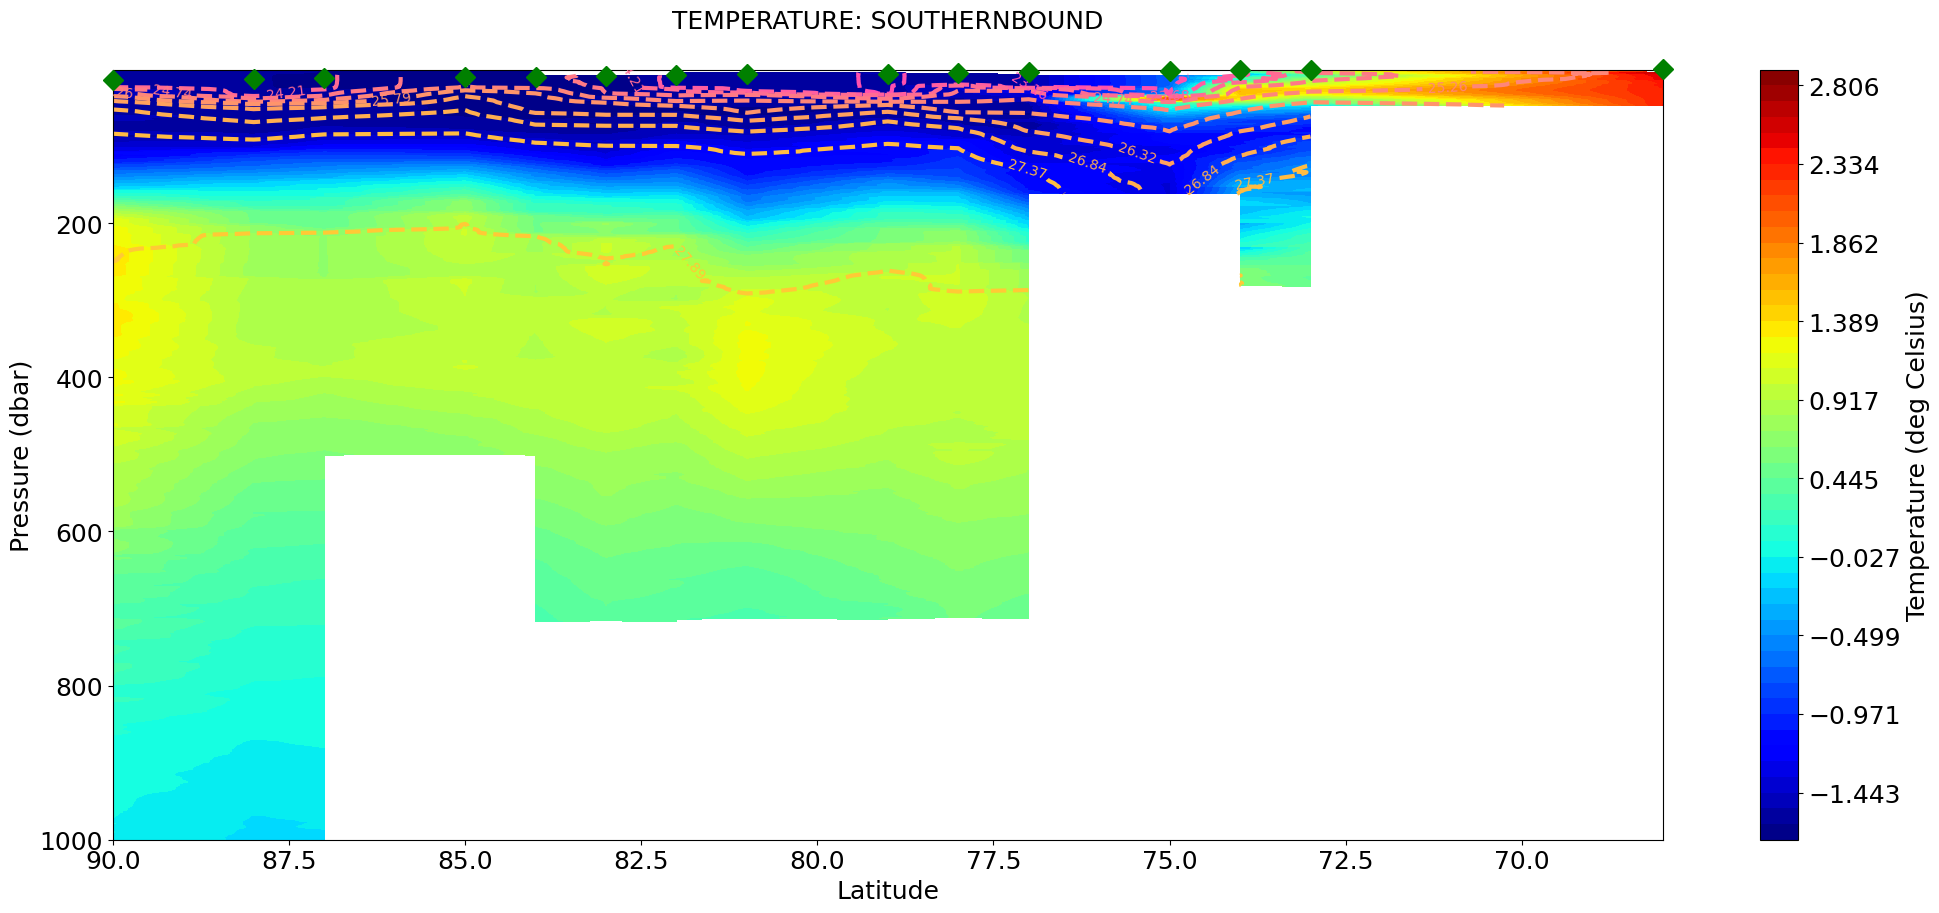

In [14]:
##Creating matrix for density tables
density_df = south_df.pivot_table(index=0, columns = 18, values=22)
density_df.dropna()
density_df.drop(index=density_df.index[0], axis=0, inplace=True)
depth3 = density_df.index
lati3 = density_df.columns
density = density_df.values.transpose()
Xi,Yi = np.meshgrid(lati3,depth3, indexing='ij')

depth2 = pivot_T.index
lati2 = pivot_T.columns
temp2 = pivot_T.values.transpose()
xi, yi = np.meshgrid(lati2,depth2,indexing='ij')
#from matplotlib.colors import LogNorm
plt.figure(figsize=(25,10))
levels = np.linspace(-1.726, 2.9)
plt.contourf(xi,yi,temp2, cmap = 'jet', levels=levels,vmin=-1.726, vmax=2.9)
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
cbar = plt.colorbar(extend ='both')
cbar.set_label('Temperature (deg Celsius)', fontsize=18)
cbar.ax.tick_params(labelsize=18)
plt.xlabel('Latitude',fontsize=18)
plt.ylabel('Pressure (dbar)' ,fontsize=18)
plt.ylim(bottom = 1000)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.plot(lati2,range(len(lati2)), 'gD',clip_on=False, markersize=10, zorder=20)
#plt.xlim(left = 80)
plt.title("TEMPERATURE: SOUTHERNBOUND", pad=30, fontsize=18)
levels2 = np.linspace(20,30,num= 20)
density = plt.contour(Xi, Yi, density , levels = levels2, linestyles = 'dashed', linewidths = 3, cmap = 'spring' )
plt.clabel(density, inline=1, fontsize=10)

plt.savefig("HLY2202_TEMP_SOUTHERNbound.png",facecolor='white',transparent = False)

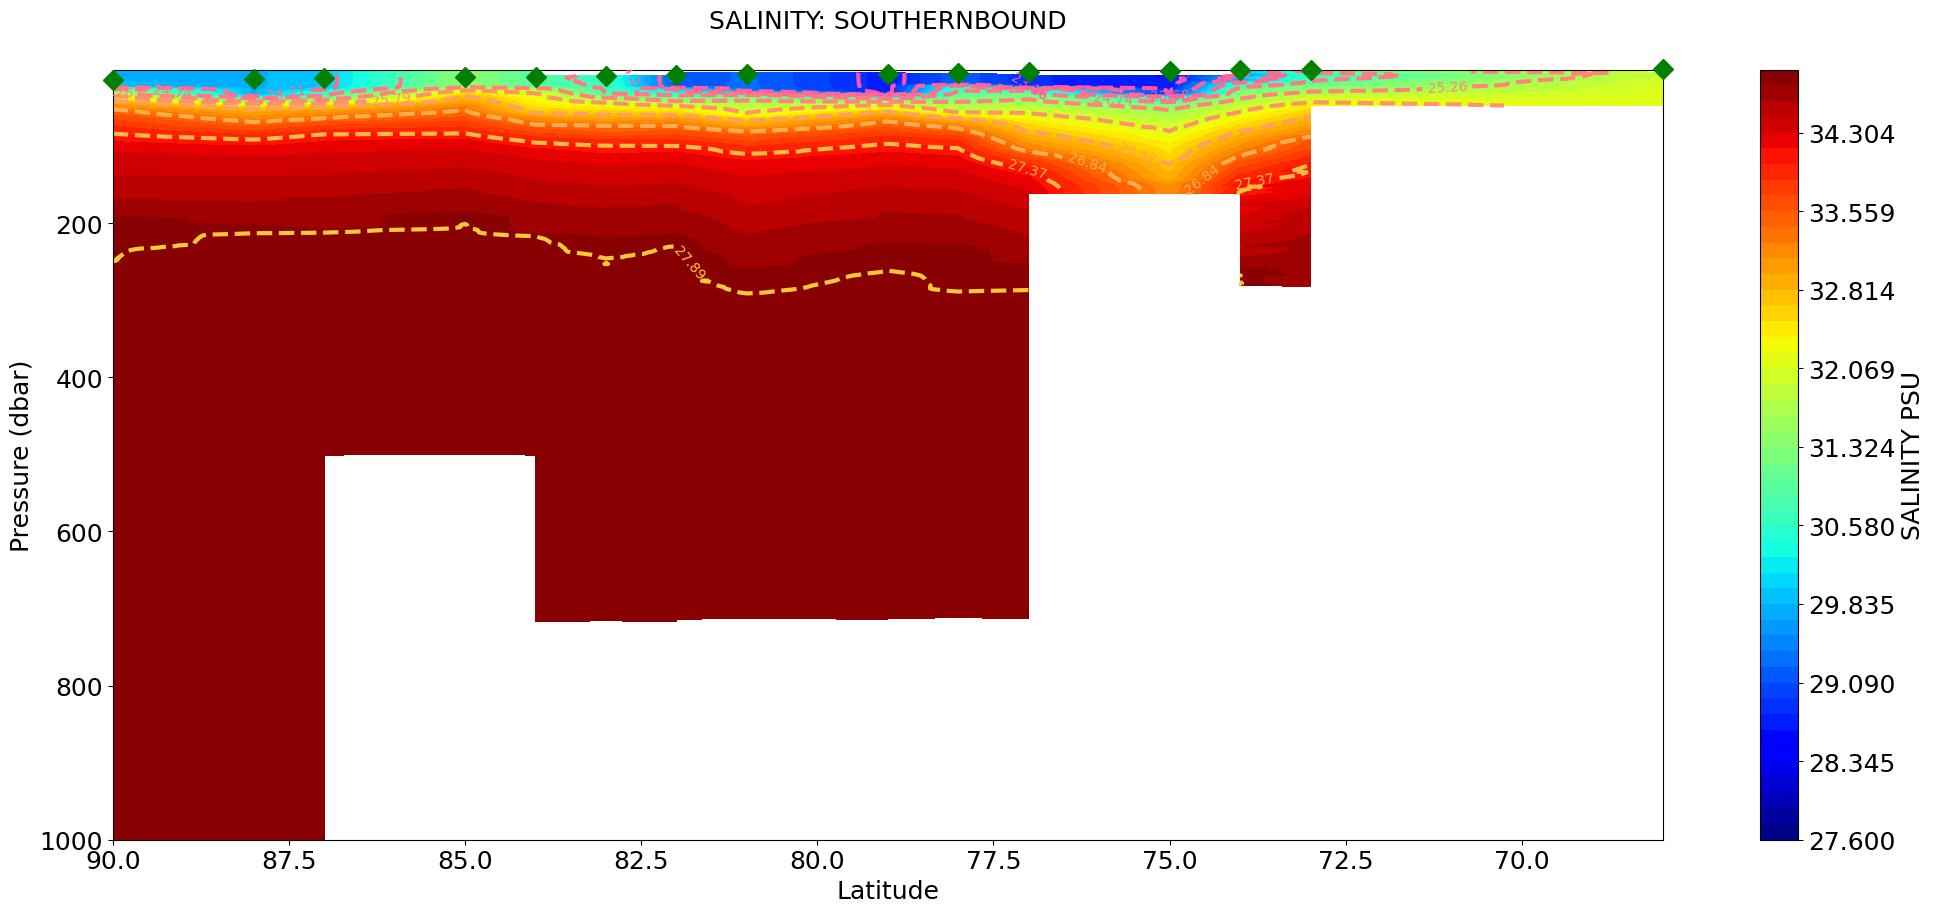

In [19]:
##Plotting for Salinity
pivot_S = south_df.pivot_table(index=0, columns = 18, values=24)

##Creating matrix for density tables
density_df = south_df.pivot_table(index=0, columns = 18, values=22)
density_df.dropna()
density_df.drop(index=density_df.index[0], axis=0, inplace=True)
depth3 = density_df.index
lati3 = density_df.columns
density = density_df.values.transpose()
Xi,Yi = np.meshgrid(lati3,depth3, indexing='ij')


depth2 = pivot_S.index
lati2 = pivot_S.columns
sal2 = pivot_S.values.transpose()
xi, yi = np.meshgrid(lati2,depth2,indexing='ij')
#from matplotlib.colors import LogNorm
plt.figure(figsize=(25,10))
levels = np.linspace(27.6, 34.9)
plt.contourf(xi,yi,sal2, cmap = 'jet', levels=levels,vmin=27.6, vmax=34.9)
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
cbar = plt.colorbar(extend ='both')
cbar.set_label('SALINITY PSU', fontsize=18)
cbar.ax.tick_params(labelsize=18)
plt.xlabel('Latitude',fontsize=18)
plt.ylabel('Pressure (dbar)' ,fontsize=18)
plt.ylim(bottom = 1000)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.plot(lati2,range(len(lati2)), 'gD',clip_on=False, markersize=10, zorder=20)
#plt.xlim(left = 80)
plt.title("SALINITY: SOUTHERNBOUND", pad=30, fontsize=18)
levels2 = np.linspace(20,30,num= 20)
density = plt.contour(Xi, Yi, density , levels = levels2, linestyles = 'dashed', linewidths = 3, cmap = 'spring' )
plt.clabel(density, inline=1, fontsize=10)

plt.savefig("HLY2202_SAL_SOUTHERNBOUND(200m).png",facecolor='white',transparent = False)